In [1]:
import os
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models import ResNet50_Weights
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import numpy as np

In [2]:
# define paths
root_dir = os.getcwd()
dataset_dir = os.path.join(root_dir, '..', 'raw_data', 'airborne_images')
resized_dir = os.path.join(root_dir, '..', 'raw_data', 'airborne_images_resized')
model_dir = os.path.join(root_dir, '..', 'models')
model_dir = os.path.normpath(model_dir)
video_dir = os.path.join(root_dir, '..', 'raw_data', 'airborne_video_output')

In [3]:
# load the saved model
def create_model(num_classes):
    backbone = resnet_fpn_backbone(
        backbone_name='resnet50',
        weights=ResNet50_Weights.IMAGENET1K_V1,
        trainable_layers=5
    )

    anchor_generator = AnchorGenerator(
        sizes=((32,), (64,), (128,), (256,), (512,)),
        aspect_ratios=((0.5, 1.0, 2.0),) * 5
    )

    model = FasterRCNN(
        backbone=backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_detections_per_img=10,
        box_nms_thresh=0.5,
        box_score_thresh=0.05
    )

    return model

num_classes = 2  # 1 for helicopter, 1 for background
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = create_model(num_classes).to(device)

# load the saved state dict
checkpoint = torch.load(os.path.join(model_dir, 'model_baseline.pth'), map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print("Model loaded successfully.")

Model loaded successfully.


In [4]:
def visualize_detection(image, prediction, threshold=0.5):
    # convert the image from tensor to numpy array
    image = image.permute(1, 2, 0).cpu().numpy()

    # get the predicted boxes, labels and scores
    boxes = prediction['boxes'].cpu().numpy()
    labels = prediction['labels'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()

    # keep detections with score above threshold
    mask = scores > threshold
    boxes = boxes[mask]
    labels = labels[mask]
    scores = scores[mask]

    # plot the image
    plt.figure(figsize=(12, 8))
    plt.imshow(image)

    # plot each box
    for box, label, score in zip(boxes, labels, scores):
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                 linewidth=2,
                                 edgecolor='r',
                                 facecolor='none')
        plt.gca().add_patch(rect)
        plt.text(box[0], box[1],
                 f'Class: {label}, Score: {score:.2f}',
                 bbox=dict(facecolor='white', alpha=0.5)
                )

    plt.axis('off')
    plt.show()

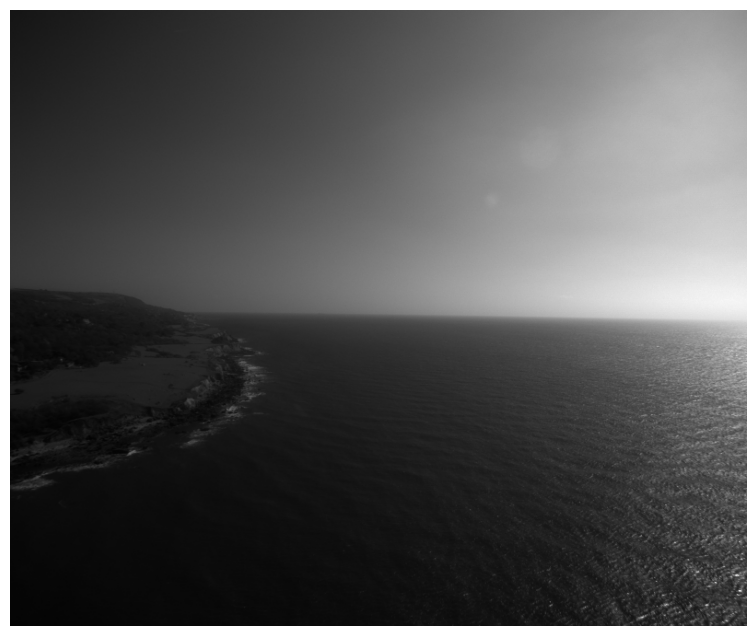

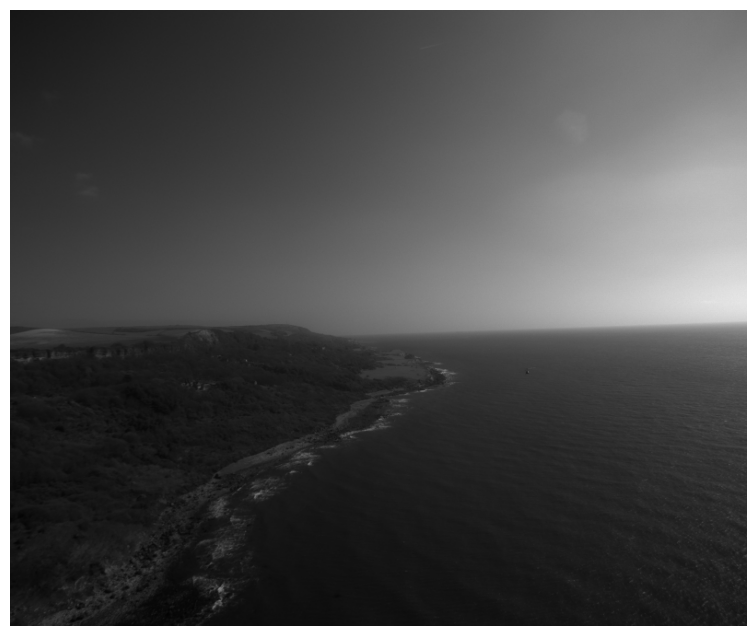

In [5]:
from PIL import Image
import torchvision.transforms as transforms

# define the transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))
])

# get a list of image files
image_files = [f for f in os.listdir(resized_dir) if f.endswith('.png')]

# run inference on a few test images
with torch.no_grad():
    for image_file in image_files[-2:]:  # visualize last 5 images
        image_path = os.path.join(resized_dir, image_file)
        image = Image.open(image_path).convert('L')
        image = transform(image).unsqueeze(0).to(device)

        prediction = model(image)[0]

        visualize_detection(image[0], prediction)

In [10]:
import cv2
import os

def create_video_from_images(image_folder, video_folder, video_name, fps=10):
    print(f"Creating video from images in {image_folder}")
    print(f"Saving video to {video_folder}")

    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    if not images:
        print(f"No PNG images found in {image_folder}")
        return

    images.sort()
    print(f"Found {len(images)} images")
    print(f"First 5 image names: {images[:5]}")

    video_path = os.path.join(video_folder, video_name)
    print(f"Attempting to create video at {video_path}")

    # Read the first image to get dimensions
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # or use 'XVID' if mp4v doesn't work
    out = cv2.VideoWriter(video_path, fourcc, fps, (width, height))

    for image in images:
        img_path = os.path.join(image_folder, image)
        frame = cv2.imread(img_path)
        if frame is None:
            print(f"Failed to read image: {img_path}")
            continue
        out.write(frame)

    out.release()

    if os.path.exists(video_path):
        print(f"Video file created successfully at {video_path}")
        print(f"Video file size: {os.path.getsize(video_path)} bytes")
    else:
        print(f"Video file not found at {video_path} after creation attempt")

# Rest of your code remains the same
root_dir = os.getcwd()
resized_dir = os.path.join(root_dir, '..', 'raw_data', 'airborne_images_resized')
video_dir = os.path.join(root_dir, '..', 'raw_data', 'airborne_video_output')
os.makedirs(video_dir, exist_ok=True)

print(f"Current working directory: {root_dir}")
print(f"Resized images directory: {resized_dir}")
print(f"Video output directory: {video_dir}")

create_video_from_images(resized_dir, video_dir, 'output_video.mp4')

Current working directory: /Users/renatoboemer/code/developer/aot-object-tracking-aws/notebooks
Resized images directory: /Users/renatoboemer/code/developer/aot-object-tracking-aws/notebooks/../raw_data/airborne_images_resized
Video output directory: /Users/renatoboemer/code/developer/aot-object-tracking-aws/notebooks/../raw_data/airborne_video_output
Creating video from images in /Users/renatoboemer/code/developer/aot-object-tracking-aws/notebooks/../raw_data/airborne_images_resized
Saving video to /Users/renatoboemer/code/developer/aot-object-tracking-aws/notebooks/../raw_data/airborne_video_output
Found 1199 images
First 5 image names: ['15549773493822188340001ba865c8e410e88609541b8f55ffc.png', '15549773494832603520001ba865c8e410e88609541b8f55ffc.png', '15549773495887103050001ba865c8e410e88609541b8f55ffc.png', '15549773497216090760001ba865c8e410e88609541b8f55ffc.png', '15549773497811591170001ba865c8e410e88609541b8f55ffc.png']
Attempting to create video at /Users/renatoboemer/code/de

In [12]:
import cv2
import os
import traceback

def create_video_from_images(image_folder, video_folder, video_name, fps=10):
    print(f"Creating video from images in {image_folder}")
    print(f"Saving video to {video_folder}")

    try:
        images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
        if not images:
            print(f"No PNG images found in {image_folder}")
            return

        images.sort()
        print(f"Found {len(images)} images")
        print(f"First 5 image names: {images[:5]}")

        video_path = os.path.join(video_folder, video_name)
        print(f"Attempting to create video at {video_path}")

        # Read the first image to get dimensions
        first_image_path = os.path.join(image_folder, images[0])
        frame = cv2.imread(first_image_path)
        if frame is None:
            print(f"Failed to read first image: {first_image_path}")
            return

        height, width, layers = frame.shape
        print(f"Image dimensions: {width}x{height}")

        # Define the codec and create VideoWriter object
        fourcc = cv2.VideoWriter_fourcc(*'avc1')
        out = cv2.VideoWriter(video_path, fourcc, fps, (width, height))

        if not out.isOpened():
            print(f"Failed to open VideoWriter for {video_path}")
            return

        for image in images:
            img_path = os.path.join(image_folder, image)
            frame = cv2.imread(img_path)
            if frame is None:
                print(f"Failed to read image: {img_path}")
                continue
            out.write(frame)

        out.release()

        if os.path.exists(video_path):
            print(f"Video file created successfully at {video_path}")
            print(f"Video file size: {os.path.getsize(video_path)} bytes")
        else:
            print(f"Video file not found at {video_path} after creation attempt")

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        print(traceback.format_exc())

# Rest of your code remains the same
root_dir = os.getcwd()
resized_dir = os.path.join(root_dir, '..', 'raw_data', 'airborne_images_resized')
video_dir = os.path.join(root_dir, '..', 'raw_data', 'airborne_video_output')
os.makedirs(video_dir, exist_ok=True)

print(f"Current working directory: {root_dir}")
print(f"Resized images directory: {resized_dir}")
print(f"Video output directory: {video_dir}")

create_video_from_images(resized_dir, video_dir, 'output_video.mp4')

# Check OpenCV version
print(f"OpenCV version: {cv2.__version__}")

Current working directory: /Users/renatoboemer/code/developer/aot-object-tracking-aws/notebooks
Resized images directory: /Users/renatoboemer/code/developer/aot-object-tracking-aws/notebooks/../raw_data/airborne_images_resized
Video output directory: /Users/renatoboemer/code/developer/aot-object-tracking-aws/notebooks/../raw_data/airborne_video_output
Creating video from images in /Users/renatoboemer/code/developer/aot-object-tracking-aws/notebooks/../raw_data/airborne_images_resized
Saving video to /Users/renatoboemer/code/developer/aot-object-tracking-aws/notebooks/../raw_data/airborne_video_output
Found 1199 images
First 5 image names: ['15549773493822188340001ba865c8e410e88609541b8f55ffc.png', '15549773494832603520001ba865c8e410e88609541b8f55ffc.png', '15549773495887103050001ba865c8e410e88609541b8f55ffc.png', '15549773497216090760001ba865c8e410e88609541b8f55ffc.png', '15549773497811591170001ba865c8e410e88609541b8f55ffc.png']
Attempting to create video at /Users/renatoboemer/code/de

OpenCV: AVF: waiting to write video data.
OpenCV: AVF: waiting to write video data.
OpenCV: AVF: waiting to write video data.
OpenCV: AVF: waiting to write video data.
OpenCV: AVF: waiting to write video data.
OpenCV: AVF: waiting to write video data.
OpenCV: AVF: waiting to write video data.
OpenCV: AVF: waiting to write video data.
OpenCV: AVF: waiting to write video data.
OpenCV: AVF: waiting to write video data.
OpenCV: AVF: waiting to write video data.
OpenCV: AVF: waiting to write video data.
OpenCV: AVF: waiting to write video data.
OpenCV: AVF: waiting to write video data.
OpenCV: AVF: waiting to write video data.
OpenCV: AVF: waiting to write video data.
OpenCV: AVF: waiting to write video data.
OpenCV: AVF: waiting to write video data.
OpenCV: AVF: waiting to write video data.
OpenCV: AVF: waiting to write video data.
OpenCV: AVF: waiting to write video data.
OpenCV: AVF: waiting to write video data.
OpenCV: AVF: waiting to write video data.
OpenCV: AVF: waiting to write vide

Video file created successfully at /Users/renatoboemer/code/developer/aot-object-tracking-aws/notebooks/../raw_data/airborne_video_output/output_video.mp4
Video file size: 26676350 bytes
OpenCV version: 4.10.0


In [16]:
import cv2
import os
import traceback
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as transforms

def create_video_from_images(image_folder, video_folder, video_name, model, device, fps=10, threshold=0.5):
    print(f"Creating video with detections from images in {image_folder}")
    print(f"Saving video to {video_folder}")

    # Define the transform
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # Repeat grayscale channel to 3 channels
    ])

    try:
        images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
        if not images:
            print(f"No PNG images found in {image_folder}")
            return

        images.sort()
        print(f"Found {len(images)} images")
        print(f"First 3 image names: {images[:3]}")

        video_path = os.path.join(video_folder, video_name)
        print(f"Attempting to create video at {video_path}")

        # Read the first image to get dimensions
        first_image_path = os.path.join(image_folder, images[0])
        frame = cv2.imread(first_image_path)
        if frame is None:
            print(f"Failed to read first image: {first_image_path}")
            return

        height, width, layers = frame.shape
        print(f"Image dimensions: {width}x{height}")

        # Define the codec and create VideoWriter object
        fourcc = cv2.VideoWriter_fourcc(*'avc1')
        out = cv2.VideoWriter(video_path, fourcc, fps, (width, height))

        if not out.isOpened():
            print(f"Failed to open VideoWriter for {video_path}")
            return

        model.eval()
        with torch.no_grad():
            for i, image in enumerate(images):
                img_path = os.path.join(image_folder, image)

                # Open image and apply transform
                pil_image = Image.open(img_path).convert('L')
                img_tensor = transform(pil_image).unsqueeze(0).to(device)

                # Run inference
                prediction = model(img_tensor)[0]

                # Convert tensor image back to numpy for OpenCV
                np_image = img_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
                np_image = (np_image * 255).astype(np.uint8)

                # Draw bounding boxes
                for box, score in zip(prediction['boxes'], prediction['scores']):
                    if score > threshold:
                        box = box.cpu().numpy().astype(int)
                        cv2.rectangle(np_image, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
                        cv2.putText(np_image, f'Score: {score:.2f}', (box[0], box[1] - 10),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

                out.write(np_image)

                if i % 100 == 0:
                    print(f"Processed {i} images")

        out.release()

        if os.path.exists(video_path):
            print(f"Video file created successfully at {video_path}")
            print(f"Video file size: {os.path.getsize(video_path)} bytes")
        else:
            print(f"Video file not found at {video_path} after creation attempt")

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        print(traceback.format_exc())

# Use the function with your model and device
root_dir = os.getcwd()
resized_dir = os.path.join(root_dir, '..', 'raw_data', 'airborne_images_resized')
video_dir = os.path.join(root_dir, '..', 'raw_data', 'airborne_video_output')
os.makedirs(video_dir, exist_ok=True)

print(f"Current working directory: {root_dir}")
print(f"Resized images directory: {resized_dir}")
print(f"Video output directory: {video_dir}")

create_video_from_images(resized_dir, video_dir, 'output_video_with_detections.mp4', model, device)

# Check OpenCV version
print(f"OpenCV version: {cv2.__version__}")

Current working directory: /Users/renatoboemer/code/developer/aot-object-tracking-aws/notebooks
Resized images directory: /Users/renatoboemer/code/developer/aot-object-tracking-aws/notebooks/../raw_data/airborne_images_resized
Video output directory: /Users/renatoboemer/code/developer/aot-object-tracking-aws/notebooks/../raw_data/airborne_video_output
Creating video with detections from images in /Users/renatoboemer/code/developer/aot-object-tracking-aws/notebooks/../raw_data/airborne_images_resized
Saving video to /Users/renatoboemer/code/developer/aot-object-tracking-aws/notebooks/../raw_data/airborne_video_output
Found 1199 images
First 5 image names: ['15549773493822188340001ba865c8e410e88609541b8f55ffc.png', '15549773494832603520001ba865c8e410e88609541b8f55ffc.png', '15549773495887103050001ba865c8e410e88609541b8f55ffc.png', '15549773497216090760001ba865c8e410e88609541b8f55ffc.png', '15549773497811591170001ba865c8e410e88609541b8f55ffc.png']
Attempting to create video at /Users/rena

KeyboardInterrupt: 